In [1]:
import time
import os

import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import *
tf.__version__

'2.3.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# Model training

## hyperparameters

In [6]:
SIZE = 10
BEST_PATH = './checkpoints/FFNN'
DISP_STEPS = 100
TRAINING_EPOCHS = 500
BATCH_SIZE = 32
LEARNING_RATE = 0.001

## data loading

In [7]:
l = np.load('./data/tot_dataset_ffnn.npz')
raw_input = l['raw_input']
raw_label = l['raw_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']
MAXS = MAXS
MINS = MINS

In [8]:
print(raw_input.shape)
print(raw_label.shape)

(137786, 20)
(137786, 5)


In [9]:
print(test_input.shape)
print(test_label.shape)

(79439, 20)
(79439, 5)


In [10]:
raw_input = raw_input.astype(np.float32)
raw_label = raw_label.astype(np.float32)
test_input = test_input.astype(np.float32)
test_label = test_label.astype(np.float32)

In [11]:
num_train = int(raw_input.shape[0]*.7)
raw_input, raw_label = shuffle(raw_input, raw_label, random_state=4574)
train_input, train_label = raw_input[:num_train, ...], raw_label[:num_train, ...]
val_input, val_label = raw_input[num_train:, ...], raw_label[num_train:, ...]

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
class FFNN(Model):
    def __init__(self, out_len):
        super(FFNN, self).__init__()
        
        self.out_len = out_len
        self.dense1 = layers.Dense(64)
        self.bn1 = layers.BatchNormalization()
        self.dense2 = layers.Dense(64)
        self.out_layer = layers.Dense(self.out_len)
        
    def call(self, inp):
        output = self.dense1(inp)
        output = self.bn1(inp)
        output = self.dense2(inp)
        output = self.out_layer(inp)
        
        return output

In [14]:
#loss inputs should be masked.
loss_object = tf.keras.losses.MeanSquaredError()
def loss_function(model, inp, tar): #RNN specialized
    
    masked_real = tar * (1 - inp[..., 5:10])
    masked_pred = model(inp) * (1 - inp[..., 5:10])
    
    return loss_object(masked_real, masked_pred)

In [15]:
ffnn_model = FFNN(test_label.shape[-1])
opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [16]:
@tf.function
def train(loss_function, model, opt, inp, tar):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss_function(model, inp, tar), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [17]:
checkpoint_path = BEST_PATH

ckpt = tf.train.Checkpoint(ffnn_model=ffnn_model,
                           opt=opt)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [18]:
writer = tf.summary.create_file_writer('tmp')

# Training

In [19]:
prev_test_loss = 100.0
with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(TRAINING_EPOCHS):
            for step, (inp, tar) in enumerate(train_dataset):
                train(loss_function, ffnn_model, opt, inp, tar)
                loss_values = loss_function(ffnn_model, inp, tar)
                tf.summary.scalar('loss', loss_values, step=step)
                
                if step % DISP_STEPS == 0:
                    test_loss = 0
                    for step_, (inp_, tar_) in enumerate(test_dataset):
                        test_loss += loss_function(ffnn_model, inp_, tar_)
                        
                        if step_ > DISP_STEPS:
                            test_loss /= DISP_STEPS
                            break
                    if test_loss.numpy() < prev_test_loss:
                        ckpt_save_path = ckpt_manager.save()
                        prev_test_loss = test_loss.numpy()
                        print('Saving checkpoint at {}'.format(ckpt_save_path))
                    print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                          .format(epoch, step, loss_values.numpy(), test_loss.numpy()))

Saving checkpoint at ./checkpoints/FFNN/ckpt-1
Epoch 0 batch 0 train loss: 0.1785 test loss: 0.2359
Saving checkpoint at ./checkpoints/FFNN/ckpt-2
Epoch 0 batch 100 train loss: 0.0791 test loss: 0.1111
Saving checkpoint at ./checkpoints/FFNN/ckpt-3
Epoch 0 batch 200 train loss: 0.0653 test loss: 0.0816
Saving checkpoint at ./checkpoints/FFNN/ckpt-4
Epoch 0 batch 300 train loss: 0.0671 test loss: 0.0662
Saving checkpoint at ./checkpoints/FFNN/ckpt-5
Epoch 0 batch 400 train loss: 0.0463 test loss: 0.0539
Saving checkpoint at ./checkpoints/FFNN/ckpt-6
Epoch 0 batch 500 train loss: 0.0321 test loss: 0.0438
Saving checkpoint at ./checkpoints/FFNN/ckpt-7
Epoch 0 batch 600 train loss: 0.0240 test loss: 0.0360
Saving checkpoint at ./checkpoints/FFNN/ckpt-8
Epoch 0 batch 700 train loss: 0.0259 test loss: 0.0297
Saving checkpoint at ./checkpoints/FFNN/ckpt-9
Epoch 0 batch 800 train loss: 0.0207 test loss: 0.0244
Saving checkpoint at ./checkpoints/FFNN/ckpt-10
Epoch 0 batch 900 train loss: 0.0113

KeyboardInterrupt: 

# Model evaluation

In [42]:
i = -1
if ckpt_manager.checkpoints:
    ckpt.restore(ckpt_manager.checkpoints[i])
    print ('Checkpoint ' + ckpt_manager.checkpoints[i][-2:] +' restored!!')

Checkpoint 34 restored!!


In [43]:
ffnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [22]:
test_loss = ffnn_model.evaluate(test_dataset)

2483/2483 [==============================] - 7s 3ms/step - loss: 0.0874


In [23]:
pred_result = ffnn_model.predict(test_dataset)

In [24]:
print(pred_result.shape)
print(test_label.shape)

(79439, 5)
(79439, 5)


In [25]:
masking = test_input[..., 5:10]

In [26]:
masked_pred = np.ma.array(pred_result, mask=masking)
masked_label = np.ma.array(test_label, mask=masking)

In [27]:
for _ in range(test_label.shape[-1]):
    print(np.sqrt(mean_squared_error(masked_label[..., _].reshape(-1), masked_pred[..., _].reshape(-1))))

0.18090835
0.27976152
0.50383985
0.14674097
0.22490889


In [28]:
r2 = RSquare()
for _ in range(test_label.shape[-1]):
    r2.reset_states()
    print(r2(masked_label[..., _][~masked_label[..., _].mask].data.reshape(-1),
             masked_pred[..., _][~masked_pred[..., _].mask].data.reshape(-1)))

tf.Tensor(0.18532956, shape=(), dtype=float32)
tf.Tensor(0.16599327, shape=(), dtype=float32)
tf.Tensor(0.019801974, shape=(), dtype=float32)
tf.Tensor(0.09593958, shape=(), dtype=float32)
tf.Tensor(0.3461625, shape=(), dtype=float32)


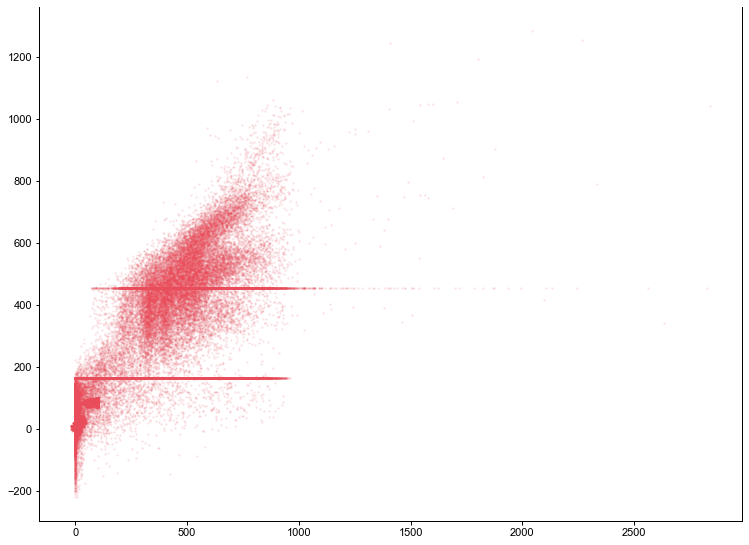

tf.Tensor(0.75389993, shape=(), dtype=float32)
111.04306379647012


In [29]:
plot_label = ((MAXS-MINS)*masked_label + MINS).reshape(-1, 1)
plot_label = plot_label[~plot_label.mask]
plot_pred = ((MAXS-MINS)*masked_pred + MINS).reshape(-1, 1)
plot_pred = plot_pred[~plot_pred.mask]
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
plt.scatter(plot_label, plot_pred, c=cmap[0], s=2, alpha=0.1)
plt.show()

r2 = RSquare()
r2.reset_states()
print(r2(plot_label, plot_pred))
print(np.sqrt(mean_squared_error(plot_label, plot_pred)))

In [30]:
test_label.shape

(79439, 5)

In [31]:
masked_pred.shape

(79439, 5)

In [32]:
pred_result.shape

(79439, 5)

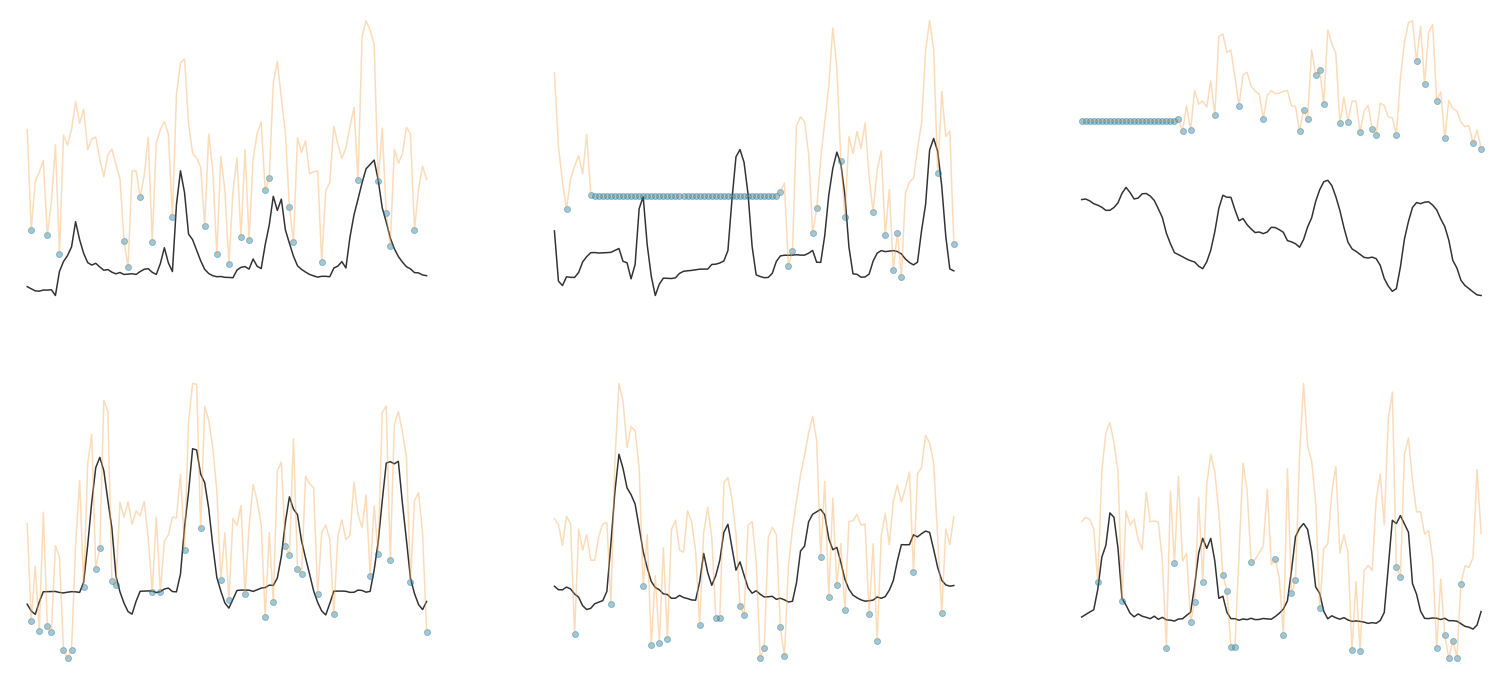

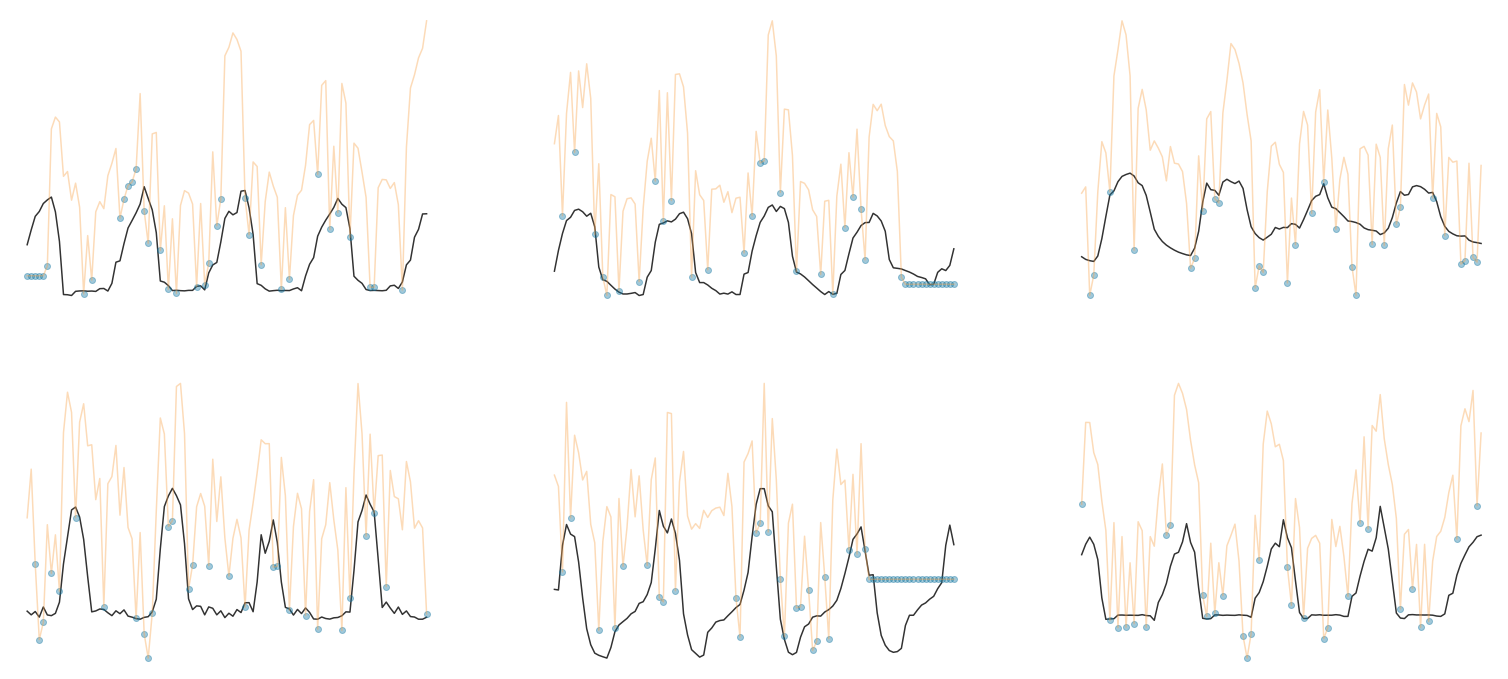

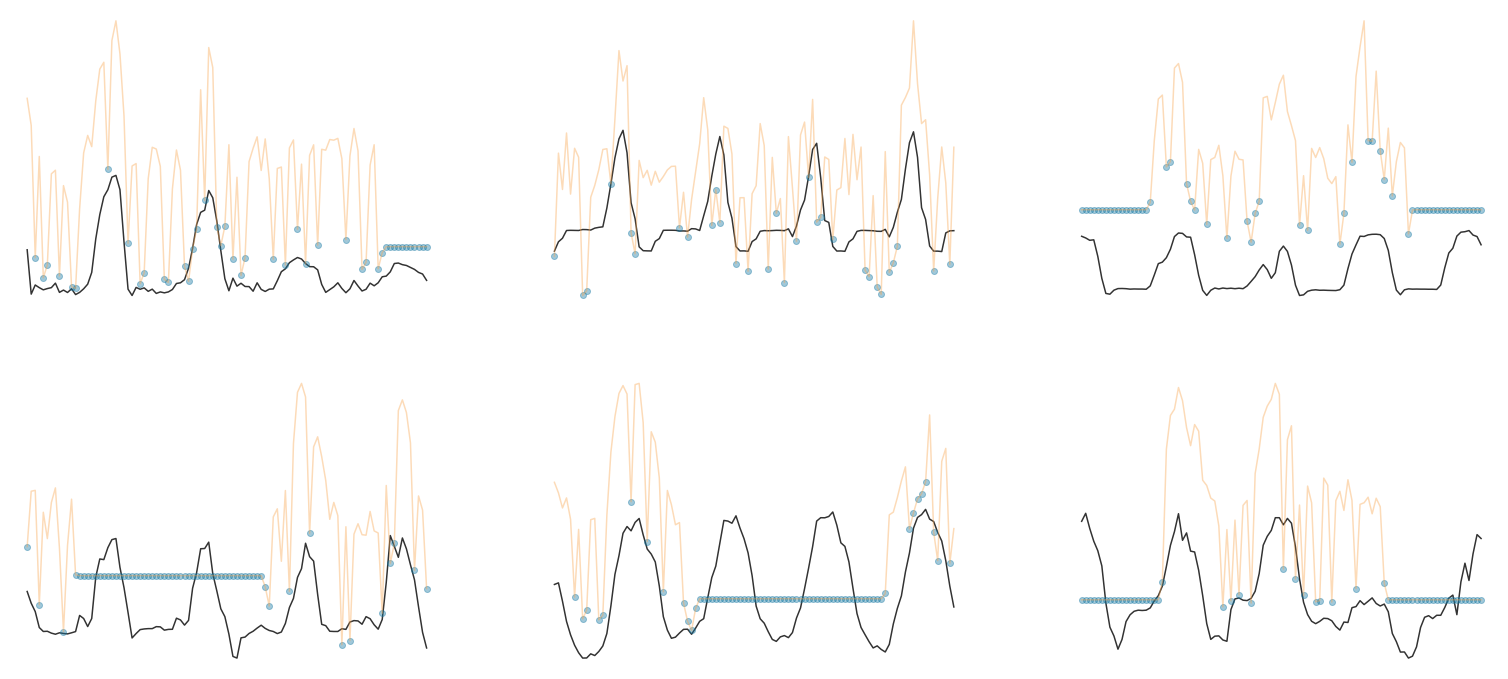

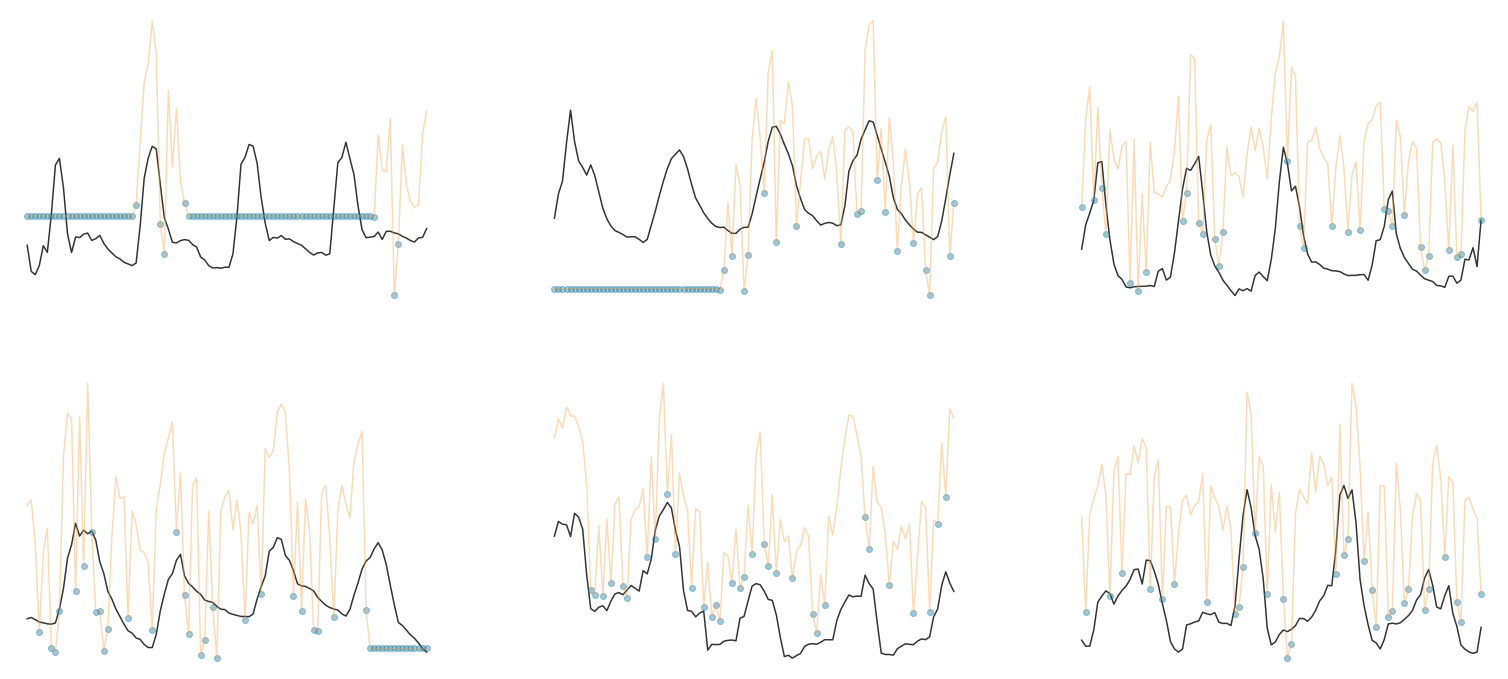

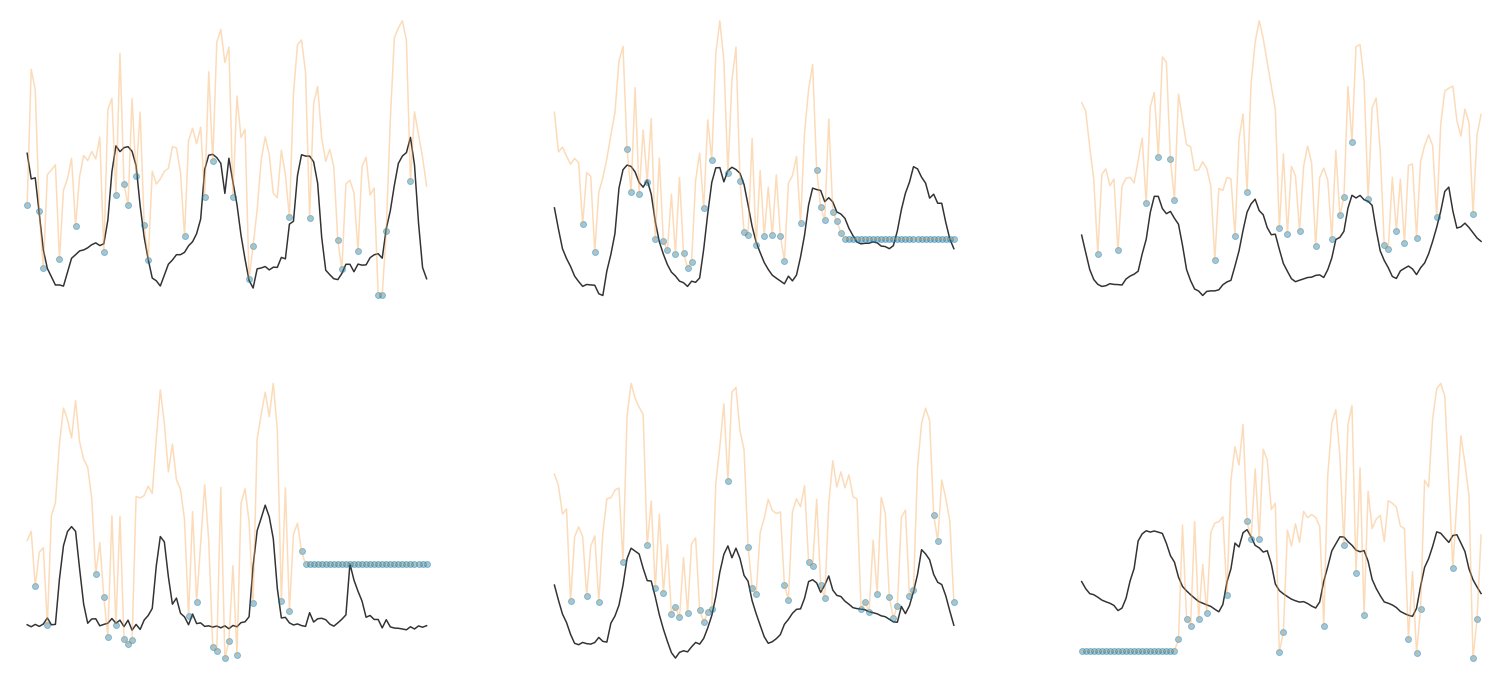

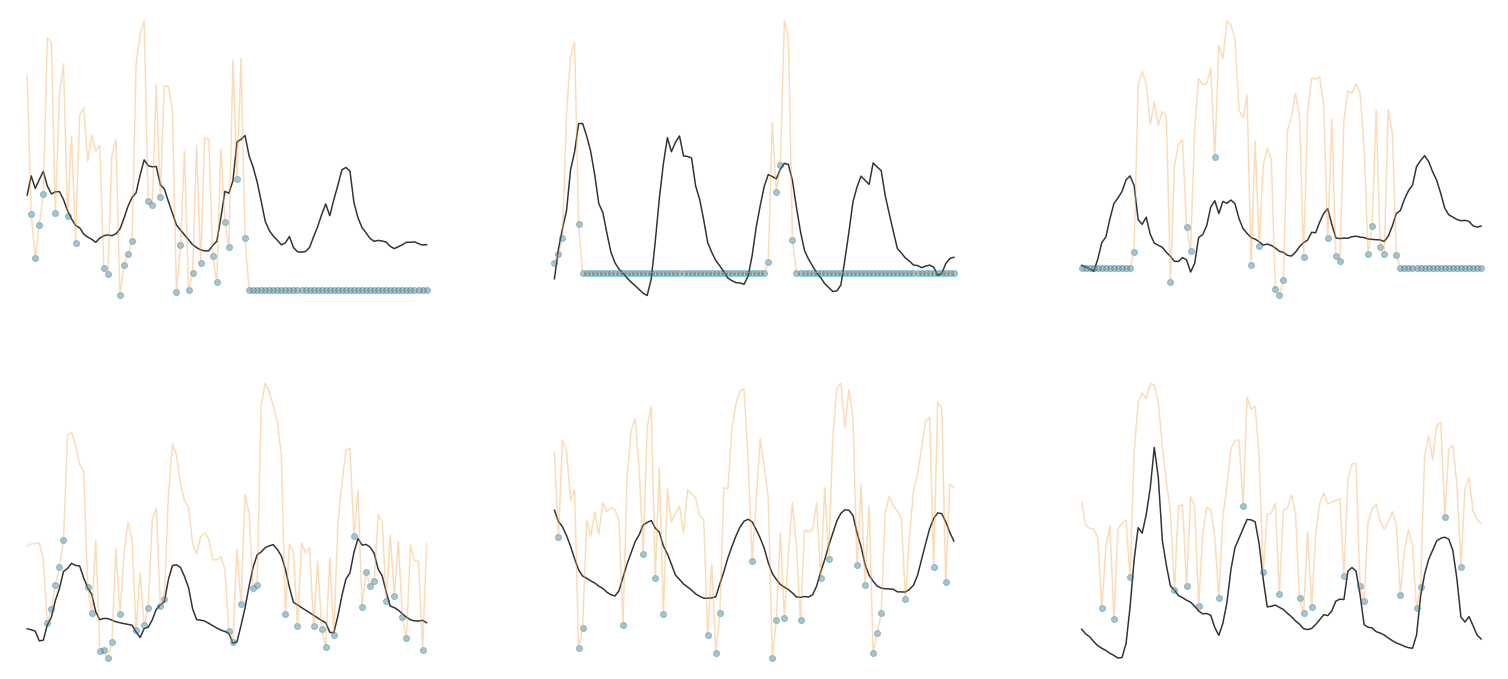

In [33]:
plot_len = 100
x_t = np.arange(0, plot_len)
for _ in range (6):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER:NUMBER+plot_len, i], c='k', alpha=0.8) #measured
            expect1 = plt.plot(x_t, masked_pred[NUMBER:NUMBER+plot_len, i], 'o', c=cmap[5], alpha=0.4) #estimated
            expect1 = plt.plot(x_t, pred_result[NUMBER:NUMBER+plot_len, i], c=cmap[2], alpha=0.4) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

In [34]:
plot_label = ((MAXS[:5]-MINS[:5])*masked_label[..., :5] + MINS[:5])
plot_label.fill_value = np.nan
plot_pred = ((MAXS[:5]-MINS[:5])*masked_pred[..., :5] + MINS[:5])
plot_pred.fill_value = np.nan

In [35]:
f = open('./results/FFNN.npz', 'wb')
np.savez(f,
         test_label = plot_label.filled(),
         test_pred = plot_pred.filled()
        )
f.close()